In [ ]:
%pip install -q torch torchvision matplotlib seaborn scikit-learn gradio

In [5]:

# --- Step 1: Import libraries ---
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

ModuleNotFoundError: No module named 'torch'

In [3]:
# Kaggle API setup assumed
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [4]:
# --- Step 3: Transformations ---
image_size = 380  # for EfficientNet-B4
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:

# --- Step 4: Datasets and Loaders ---
dataset_path = 'brain_tumor_dataset'
train_dataset = datasets.ImageFolder(root=f'{dataset_path}/Training', transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f'{dataset_path}/Testing', transform=val_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
# --- Step 5: Model Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 169MB/s]


In [7]:
# Replace classifier head
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(classes))
)


In [8]:
#Load the full model into gpu
model = model.to(device)

In [9]:
# Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

In [10]:

# --- Step 6: Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:

epochs = 20
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = np.inf
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch 1/20 -> Train Loss: 0.6131, Train Acc: 78.73% | Val Loss: 1195.1580, Val Acc: 81.46%
Epoch 2/20 -> Train Loss: 0.3776, Train Acc: 86.55% | Val Loss: 924.1773, Val Acc: 83.30%
Epoch 3/20 -> Train Loss: 0.3295, Train Acc: 87.87% | Val Loss: 2437.2637, Val Acc: 85.89%
Epoch 4/20 -> Train Loss: 0.3085, Train Acc: 88.67% | Val Loss: 1859.4132, Val Acc: 86.96%
Epoch 5/20 -> Train Loss: 0.2827, Train Acc: 89.76% | Val Loss: 656.2579, Val Acc: 87.26%
Epoch 6/20 -> Train Loss: 0.2749, Train Acc: 89.78% | Val Loss: 4123.9298, Val Acc: 87.87%
Epoch 7/20 -> Train Loss: 0.2574, Train Acc: 90.18% | Val Loss: 5675.4631, Val Acc: 89.09%
Epoch 8/20 -> Train Loss: 0.2544, Train Acc: 90.28% | Val Loss: 451.8538, Val Acc: 88.94%
Epoch 9/20 -> Train Loss: 0.2410, Train Acc: 91.28% | Val Loss: 3959.5684, Val Acc: 88.71%
Epoch 10/20 -> Train Loss: 0.2309, Train Acc: 91.16% | Val Loss: 8640.9347, Val Acc: 88.18%
Epoch 11/20 -> Train Loss: 0.2341, Train Acc: 91.07% | Val Loss: 289.1170, Val Acc: 90.08%
E

In [12]:
# --- Step 8: Evaluation ---
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


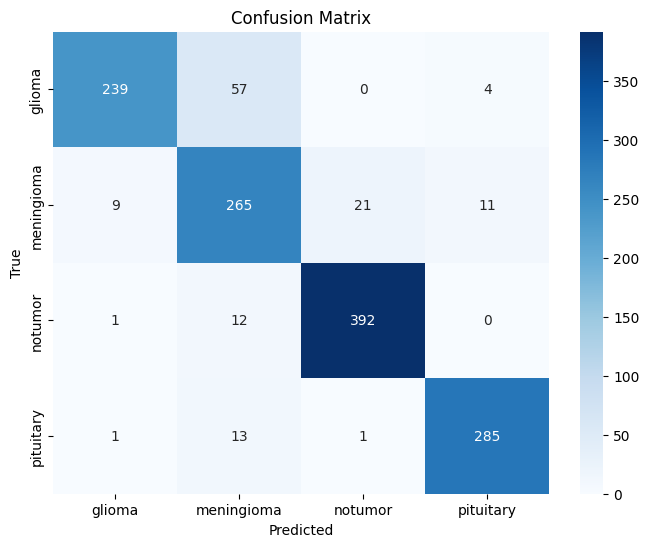

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87       300
  meningioma       0.76      0.87      0.81       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.95      0.95      0.95       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



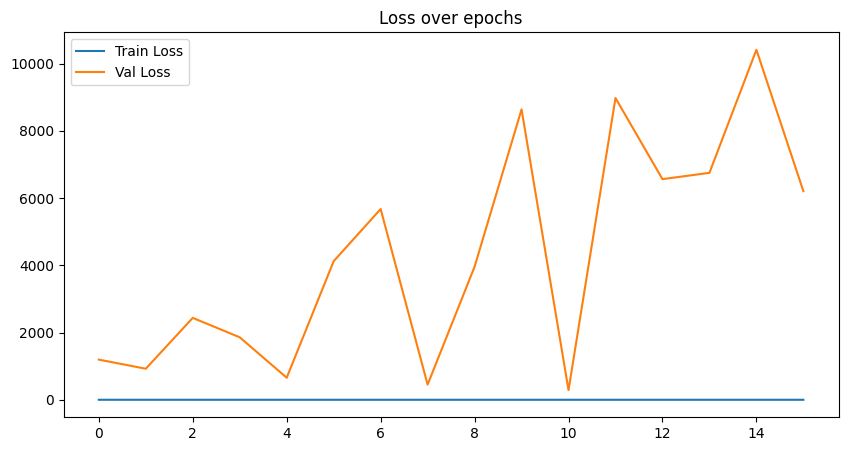

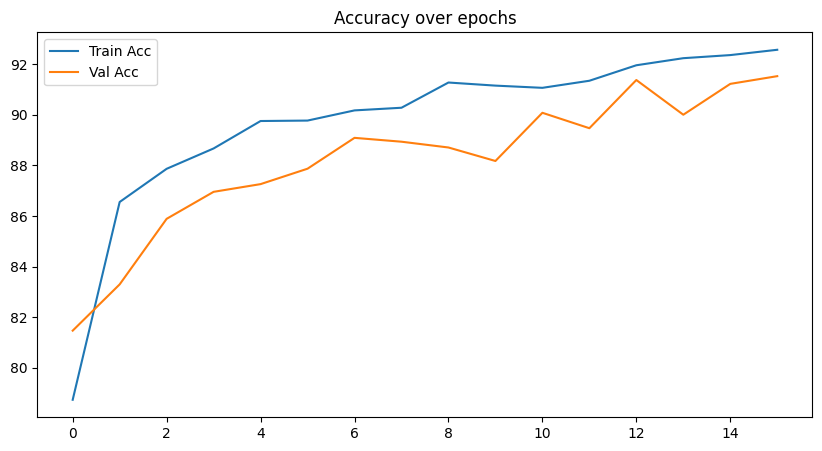

In [15]:
# --- Step 9: Loss and Accuracy Plots ---
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()


In [16]:
from google.colab import files
files.download('best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import datetime

# Create timestamp
timestamp = datetime.datetime.now().strftime("%d_%m_%Y")

# Filename with timestamp
model_save_path = f"best_model_{timestamp}.pth"

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved as {model_save_path}")

Model saved as best_model_26_04_2025.pth


In [20]:
torch.save(model, 'full_model.pth')

In [26]:
# prompt: i want to make a predict function that will predict the name of the class and i want gradio interface for user to upload the file to predict the class name

!pip install gradio
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image

from torchvision.models import efficientnet_b4

# Add EfficientNet to the safe globals
torch.serialization.add_safe_globals([efficientnet_b4])

# Load the model
model = torch.load('full_model.pth', map_location=torch.device('cpu'),weights_only=False)
model.eval()

# Define image transformations
image_size = 380

classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def predict(image):
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    image = val_transforms(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return classes[predicted.item()]

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Brain Tumor Classification",
    description="Upload a brain MRI image to predict the tumor type."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca6f4170e5f357845e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
